In [132]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



In [133]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [134]:

#load pretrained model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

#modify output layer for 2 classes - for this case the classes are regular frogs and noisy frogs
#but for the project it would be poisoned vs non-poisoned images
model.fc = torch.nn.Linear(num_ftrs, 2)



In [135]:
#freeze earlier layers - this is optional and it may work better to NOT freeze the earlier layers
for param in model.parameters():
    param.requires_grad = False
    for name, param in model.named_parameters():
        if "fc" in name:
            param.requires_grad = True 


In [136]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.ImageFolder(root="data/frogs/train",transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root="data/frogs/train",transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)


EPOCHS=40
BATCH_SIZE = 32
TOTAL_SIZE = 5854
#TOTAL_TEST_SIZE = 
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE

TOTAL_TEST_SIZE = 200
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [137]:
trainset

Dataset ImageFolder
    Number of datapoints: 5855
    Root location: data/frogs/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [138]:
trainset.classes

['cleanfrog', 'realNoisyFrogs']

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.0007
)  # lr should be kept low so that the pre-trained weights don't change easily

In [144]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(testloader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

                for i in range(BATCH_SIZE):
                    a = []
                    for j in output[i]:
                        a.append(float(j.detach()))
    
                    pred = a.index(max(a))
    
                    if pred == int(target[i]):
                        correct = correct + 1
    
                    else:
                        incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )

In [142]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 113 INCORRECT: 79 TEST ACCURACY: 0.5885416666666666
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.5885416666666666 LOSS : 0.7239749431610107


In [145]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []


loss_history = []
accuracy_history = []

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(trainloader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        for p in range(BATCH_SIZE):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)

    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model.state_dict(), "model_save/model.pth") # Saving our best model


-----------------------EPOCH 0 -----------------------------------


NameError: name 'total' is not defined

In [99]:
print("ACCURACY : ",new_best)

ACCURACY :  0.2847222222222222


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

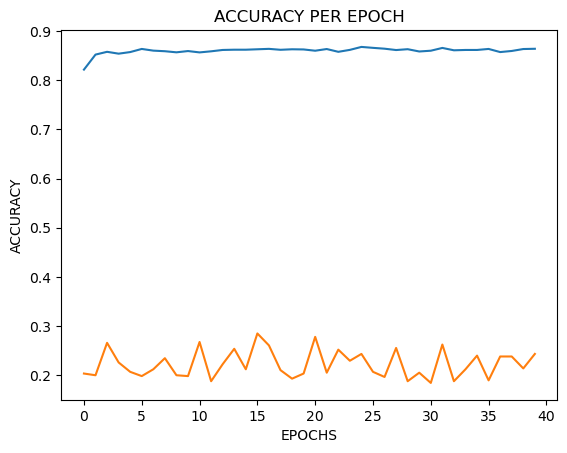

In [100]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend